# Import Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df_1 = pd.read_csv('banknifty.csv')

## Preprocessing Data

In [3]:
def Date_Time(dataFrame):
    dateTime = dataFrame['date'].map(str)+dataFrame['time']
    k = pd.to_datetime(dateTime, format='%Y%m%d%H:%M')
    dataFrame['DateTime'] = k
    
    dataFrame['Day'] = dataFrame['DateTime'].dt.day
    dataFrame['Month'] = dataFrame['DateTime'].dt.month
    dataFrame['Year'] = dataFrame['DateTime'].dt.year
    dataFrame['Hour'] = dataFrame['DateTime'].dt.hour
    dataFrame['Minute'] = dataFrame['DateTime'].dt.minute
    
    dataFrame = dataFrame.drop(labels=['DateTime'], axis=1)
    dataFrame['group']= dataFrame['Year'].map(str) + dataFrame['Month'].map(str)+ dataFrame['Day'].map(str) + dataFrame['Hour'].map(str)

    dataFrame = dataFrame[['open', 'high', 'low', 'Day', 'Month', 'Year', 'Hour',
       'Minute','group','close']]
    
    dataFrame= dataFrame.sort_values(by=['Year','Month','Day','Hour'])
    dataFrame= dataFrame.reset_index(drop=True)
    
    return(dataFrame)

In [4]:
def processing(dataframe):
    df = dataframe
    
    hour_group = df['group'].unique() # extract unique hour values to form group based on days, month and year
    h_group_index = np.arange(1,len(hour_group)+1)# for reindexing hour group values from 1 to number of groups.
    #As indexing starts from 0 so 1 is added
    
    # replacing hour group values with new indexing for extracting hour groups
    #(This step will take 20 minutes due to 3 hundred thousand samples)
    # it is already done once and results are saved in file hour.npy
    # so instead of running again, load this file
    '''
    for i in range(len(hour_group)):
        df['group'] = df['group'].replace([hour_group[i]],h_group_index[i])
    '''
    df['group'] = np.load('hours.npy')
        
    count_index = df['close'].groupby(df['group']).count() # counting each day group values
    
    hour_index = []  # extracting months index
    w=0
    for i in count_index:
        w = i+w
        hour_index.append(w)
    hour_index = np.array(hour_index) -1 # subtracting with -1 as indexing starts from 0 instead of 1
    # above steps are adding count values(in other words "commulative count_index") 
    # we need commulative count_index as count_index are absolute values from which required values cant be extracted
    
    # extracting close values which is last value of each month group
    close = []
    for i in hour_index:
        t = df.loc[i,'close']
        close.append(t)
    close = np.array(close)
    
    #extracting low, high, month, year values of each month group
    # index is resetted because extracted group values keeps previous dataframe indexes 
    low = pd.DataFrame(df['low'].groupby(df['group']).min()).reset_index(drop=True)
    high = pd.DataFrame(df['high'].groupby(df['group']).max()).reset_index(drop=True)
    Day = pd.DataFrame(df['Day'].groupby(df['group']).max()).reset_index(drop=True)
    Month = pd.DataFrame(df['Month'].groupby(df['group']).max()).reset_index(drop=True)
    Year = pd.DataFrame(df['Year'].groupby(df['group']).max()).reset_index(drop=True)
    Hour = pd.DataFrame(df['Hour'].groupby(df['group']).max()).reset_index(drop=True)
    
    #extracting first value of open from each month group
    openn = []
    for i in (hour_index-count_index+1):
        r = df.loc[i,'open']
        openn.append(r)
    openn = np.array(openn)
    
    #creating new data frame with extracted values 
    df2 = pd.DataFrame()
    
    df2['open'] = openn
    df2['high'] = high
    df2['low'] = low
    df2['Day'] = Day
    df2['Month'] = Month
    df2['Year'] = Year
    df2['Hour'] = Hour
    df2['close'] = close

    
    return(df2)

In [5]:
def scaling(dataFrame):

    close = np.array(dataFrame['close']).reshape(-1,1)
    stock_df = dataFrame.drop(labels=['close'], axis = 1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(stock_df)
    scaled_df = scaler.transform(stock_df)
    
    scaler2 = MinMaxScaler(feature_range=(0,1))
    scaler2.fit(close)
    scaled_close = scaler2.transform(close)
    
    scaled_df = pd.DataFrame(scaled_df, columns=stock_df.columns)
    scaled_df['close'] = scaled_close
    
    return(scaled_df, scaler, scaler2)

In [6]:
stock_df1 = Date_Time(df_1)

In [7]:
stock_df1.head()

,open,high,low,Day,Month,Year,Hour,Minute,group,close
0,11276.55,11276.55,11265.80,1,11,2012,9,16,20121119,11268.90
1,11267.95,11267.95,11258.85,1,11,2012,9,17,20121119,11260.05
2,11259.45,11259.45,11243.90,1,11,2012,9,18,20121119,11243.90
3,11246.50,11246.60,11237.90,1,11,2012,9,19,20121119,11238.90
4,11241.15,11247.20,11239.30,1,11,2012,9,20,20121119,11245.30


In [8]:
stock_df1_1 = processing(stock_df1)

In [9]:
stock_df1_1.head(10)

,open,high,low,Day,Month,Year,Hour,close
0,11276.55,11320.65,11230.20,1,11,2012,9,11301.85
1,11303.30,11305.85,11255.25,1,11,2012,10,11267.00
2,11266.50,11344.90,11256.10,1,11,2012,11,11328.50
3,11324.40,11344.55,11317.35,1,11,2012,12,11327.45
4,11332.80,11349.40,11303.20,1,11,2012,13,11325.15
5,11324.70,11333.45,11298.80,1,11,2012,14,11324.25
6,11324.15,11326.20,11299.10,1,11,2012,15,11306.25
7,11442.85,11446.05,11398.35,2,11,2012,9,11436.70
8,11438.20,11440.05,11406.40,2,11,2012,10,11422.75
9,11421.95,11429.25,11394.15,2,11,2012,11,11426.65


In [10]:
stock_df2, in_scaler, out_scaler = scaling(stock_df1_1)

In [11]:
stock_df2.head()

,open,high,low,Day,Month,Year,Hour,close
0,0.507543,0.508050,0.514885,0.0,0.909091,0.0,0.0,0.508640
1,0.508919,0.507291,0.516198,0.0,0.909091,0.0,0.1,0.506847
2,0.507026,0.509294,0.516242,0.0,0.909091,0.0,0.2,0.510011
3,0.510005,0.509276,0.519452,0.0,0.909091,0.0,0.3,0.509957
4,0.510437,0.509525,0.518710,0.0,0.909091,0.0,0.4,0.509838


## Data Plots

In [12]:
import seaborn as sns

#### Time Series Distribution For Month

Text(0, 0.5, 'Stock Rate')

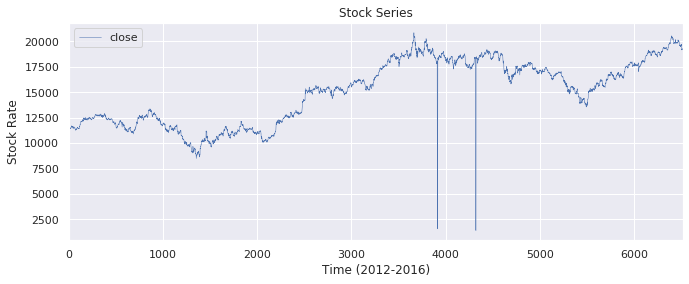

In [13]:
sns.set(rc={'figure.figsize':(11,4)})
stock_df1_1[['close']].plot(linewidth=0.5, title='Stock Series')
plt.xlabel('Time (2012-2016)')
plt.ylabel('Stock Rate')

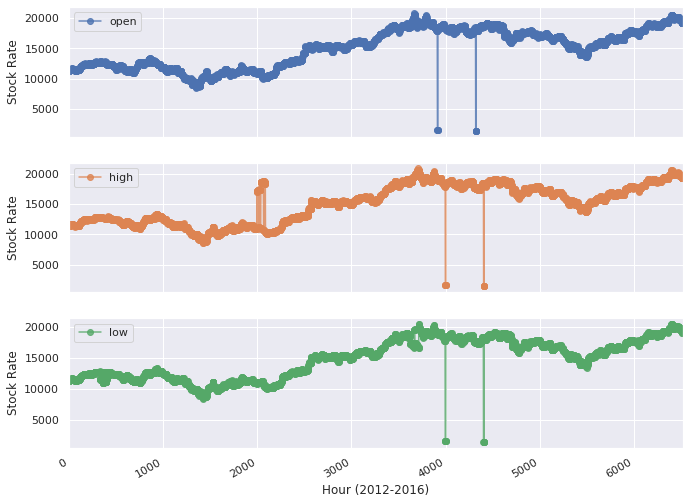

In [14]:
cols_plot = ['open', 'high','low']
axes = stock_df1_1[cols_plot].plot(marker='o', alpha=0.8, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Stock Rate')
    ax.set_xlabel('Hour (2012-2016)')

#### Box Pots

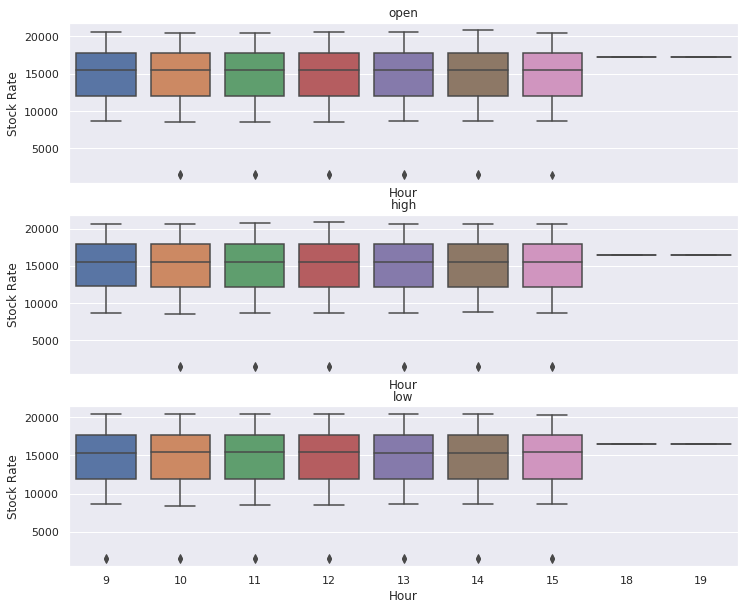

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.boxplot(data=stock_df1_1, x='Hour', y=name, ax=ax)
    ax.set_ylabel('Stock Rate')
    ax.set_title(name)

#### Heat Map

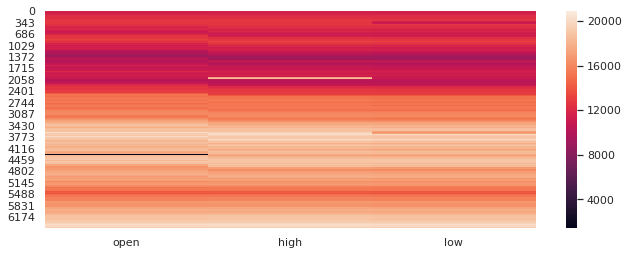

In [14]:
sns.heatmap(stock_df1_1[['open','high','low']])

#### Histograms and Curve Distribution

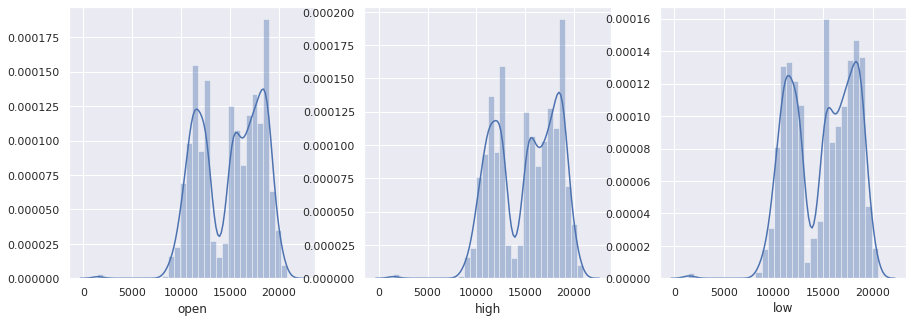

In [15]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
for name, ax in zip(['open', 'high', 'low'], axes):
    sns.distplot(stock_df1_1[name], ax=ax)

#### Correlation

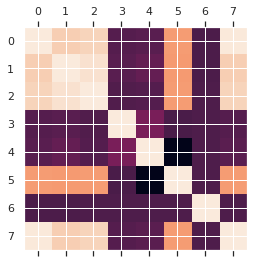

In [16]:
plt.matshow(stock_df1_1.corr())
plt.show()

#### Scatter Plot

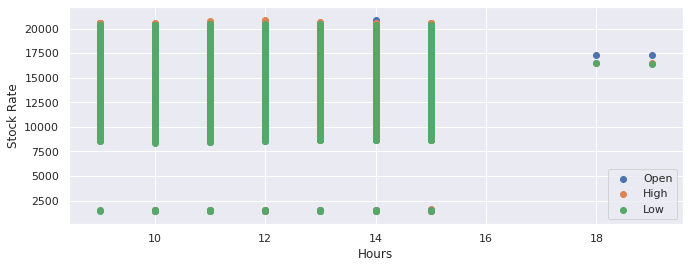

In [17]:
plt.scatter(stock_df1_1['Hour'],stock_df1_1['open'])
plt.scatter(stock_df1_1['Hour'],stock_df1_1['high'])
plt.scatter(stock_df1_1['Hour'],stock_df1_1['low'])
plt.legend(['Open','High','Low'])
plt.xlabel('Hours')
plt.ylabel('Stock Rate')
plt.show()

#### Trend

Text(0.5, 0, 'Hours')

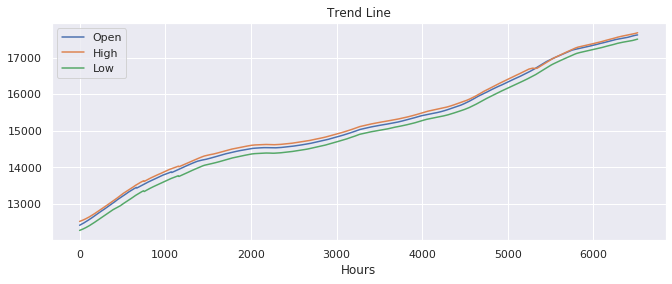

In [18]:
plt.plot(stock_df1_1['open'].rolling(window=6500, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['high'].rolling(window=6500, center=True, min_periods=30).mean())
plt.plot(stock_df1_1['low'].rolling(window=6500, center=True, min_periods=30).mean())
plt.legend(['Open','High','Low'])
plt.title('Trend Line')
plt.xlabel('Hours')

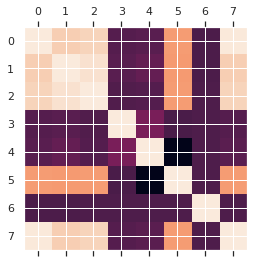

In [16]:
plt.matshow(stock_df2.corr())
plt.show()

## Splitting Data into Train/Test

In [14]:
def train_test_data(data):
    x = np.array(data.iloc[:,:-1])
    y = np.array(data.iloc[:,-1])
    
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, shuffle= True)
    
    return (x_train, x_test, y_train, y_test)

In [15]:
x_train_df1, x_test_df1, y_train_df1, y_test_df1 = train_test_data(stock_df2)

In [16]:
x_train_df1.shape

(5212, 7)

In [17]:
y_train_df1.shape

(5212,)

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rf = RandomForestRegressor(verbose=1)

In [20]:
rf.fit(x_train_df1, y_train_df1)

/home/kirmani/anaconda3/envs/env1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=1, warm_start=False)

In [21]:
pred = rf.predict(x_test_df1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [22]:
# Output value is scaled. To get actual value undo scaled value of output
print('Scaled Value Predicted: %.2f' %pred[2])
print('Actual Predicted Value: %.2f'%out_scaler.inverse_transform([[pred[2]]]))
print('True Value: %.2f' %out_scaler.inverse_transform([[y_test_df1[2]]]))

Scaled Value Predicted: 0.83
Actual Predicted Value: 17554.79
True Value: 17607.40


### Random Forest Evaluation

In [23]:
print('R_2 Score: %.7f' %r2_score(y_test_df1, pred))
print('Mean Absolute Error: %.7f' %mean_absolute_error(y_test_df1, pred))
print('Mean Square Error: %.7f' %mean_squared_error(y_test_df1, pred))
print('Root Mean Square Error: %.7f' %np.sqrt(mean_squared_error(y_test_df1, pred)))

R_2 Score: 0.9594981
Mean Absolute Error: 0.0042307
Mean Square Error: 0.0010913
Root Mean Square Error: 0.0330343


### Random Forest Plots

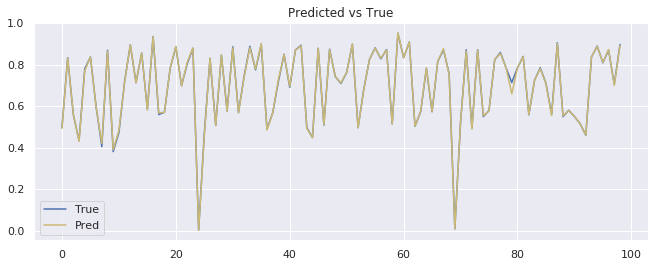

In [24]:
plt.plot(y_test_df1[1:100], 'b')
plt.plot( pred[1:100], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.show()

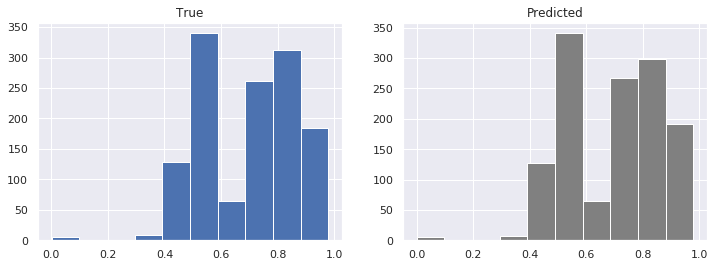

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y_test_df1)
plt.title('True')

plt.subplot(1,2,2)
plt.hist(pred, color='grey')
plt.title('Predicted')
plt.show()

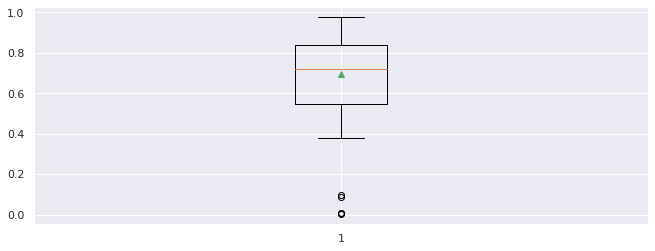

In [26]:
plt.boxplot(pred, showmeans=True)
plt.show()

## Time Based Prediction Plot

In [27]:
true = out_scaler.inverse_transform([y_test_df1]) # true values without scaling
result = out_scaler.inverse_transform([pred])  # predicted values without scaling

In [28]:
tm = in_scaler.inverse_transform(x_test_df1)  # descaling test input values

In [29]:
tm1 = tm[:,3]   # descaling Test set Day values
tm2 = tm[:,4]   # descaling Test set Month values
tm3 = tm[:,5]   # descaling Test set Year values
tm4 = tm[:,6]   # descaling Test set Hour values

In [30]:
# Result DataFrame without scaled values for true and predicted
res = pd.DataFrame()
res['Hour'] = tm4.astype(int)
res['Day'] = tm1.astype(int)
res['Month'] = tm2.astype(int)
res['Year'] = tm3.astype(int)
res['True'] = np.squeeze(true)
res['Predicted'] = np.squeeze(result)
res['Time'] = res['Hour'].map(str) +'-' + res['Day'].map(str) +'-' +res['Month'].map(str) +'-' + res['Year'].map(str)

In [31]:
# Sorting result values according to time in ascending order and resetting index
res1 = res.sort_values(by=['Year','Month','Day','Hour'])
res1 = res1.reset_index(drop=True)

In [32]:
res1.head()

,Hour,Day,Month,Year,True,Predicted,Time
0,14,1,11,2012,11324.25,11305.952639,14-1-11-2012
1,12,2,11,2012,11450.25,11446.141056,12-2-11-2012
2,10,3,11,2012,12093.15,12126.324738,10-3-11-2012
3,11,3,11,2012,12093.95,12094.611061,11-3-11-2012
4,10,4,11,2012,12172.25,12126.186905,10-4-11-2012


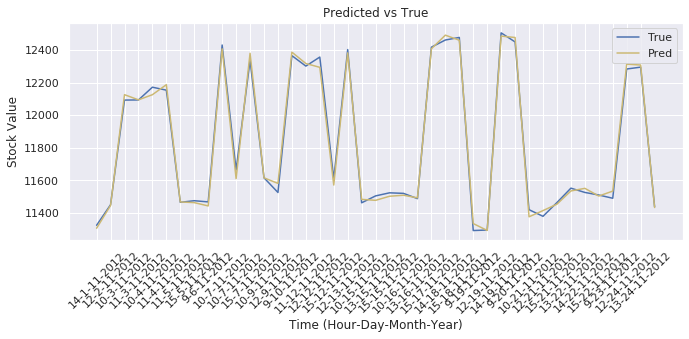

In [33]:
# First 40 Test Set Points Plot
plt.plot(res1.loc[:40,'True'], 'b')
plt.plot( res1.loc[:40,'Predicted'], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
# for displaying day time x-axis labels uncomment the next line
plt.xticks(ticks=np.arange(40), labels=res1.loc[:40,'Time'], rotation = 45)
plt.ylabel('Stock Value')
plt.xlabel('Time (Hour-Day-Month-Year)')
plt.show()

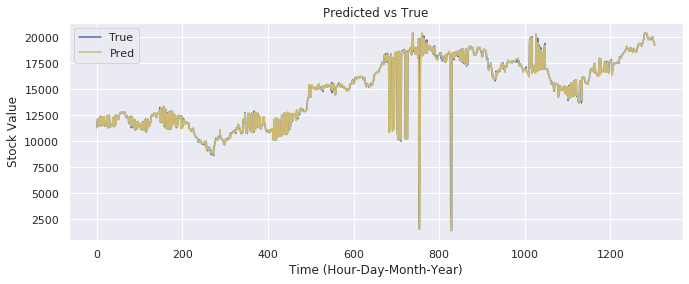

In [34]:
# Complete Test Set Plot
plt.plot(res1['True'], 'b')
plt.plot( res1['Predicted'], 'y')
plt.legend(['True', 'Pred'])
plt.title('Predicted vs True')
plt.ylabel('Stock Value')
plt.xlabel('Time (Hour-Day-Month-Year)')
plt.show()

## User Input Data

In [75]:
def user():
    u = input('Do you want to enter custom data sample? Enter "y" or "n" :')
    if u == 'y':
        print('\nStock value range is 1400-21000')
        openn = float(input('Enter Opening Stock Value of the day: '))
        high = float(input('Enter Highest Stock Value of the day: '))
        low = float(input('Enter Lowest Stock Value of the day: '))
        date = str(input('Enter Date and time in format (21/03/201914:02) : '))
        
        new_data = np.array([[openn, high, low, date]])
    else:
        new_data = None
    
    
                       
    return new_data

In [76]:
def u_output(u_dt):
    user_df = pd.DataFrame(u_dt, columns=['Open','High', 'Low', 'Date'])
    user_dt = pd.to_datetime(user_df['Date'], format='%d/%m/%Y%H:%M')
    
    user_df2 = user_df.drop(labels=['Date'], axis=1)
    
    user_df2['Day'] = user_dt.dt.day
    user_df2['Month'] = user_dt.dt.month
    user_df2['Year'] = user_dt.dt.year
    user_df2['Hour'] = user_dt.dt.hour
      
    sca_user_df1 = in_scaler.transform(user_df2)

    user_df1 = pd.DataFrame(sca_user_df1, columns=user_df2.columns)
    
    u_pred = rf.predict(np.array(user_df1))
    u_real1 = out_scaler.inverse_transform([u_pred]) 
    
    return(u_real1)

In [77]:
user_data = user()

Do you want to enter custom data sample? Enter "y" or "n" :y

Stock value range is 1400-21000
Enter Opening Stock Value of the day: 2450
Enter Highest Stock Value of the day: 5468
Enter Lowest Stock Value of the day: 3211
Enter Date and time in format (21/03/201914:02) : 23/11/201912:00


In [78]:
if user_data is None:
    print('Process Completed')
else:
    o1 = u_output(user_data)
    print('Stock Closing is at: %.2f'%o1)

Stock Closing is at: 11996.49


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
